In [4]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
%matplotlib notebook
%matplotlib inline

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose

# ipysh.Bootstrap_support.debug()

In [5]:

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       

# TEST QSH


In [6]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBt_rm','argBt_rm']) 

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [4]:
def _map(xy,p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return (xy,pBr),(xy,pBr)
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,y,br: _map(x,y,br) )
# [x for x in ds.shuffle(100).batch(1).take(1)][0]

In [7]:
m1 = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30,  dprate=0., scale=1, geometry=[20,20,10,10], beta=1e-5, name='m1') #beta=0.001)
m2 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=44,  dprate=0., scale=1, geometry=[20,20,10,10], beta=1e-5,name='m2') # parameters

AEFIT5 ready m:
AEFIT5 ready m:


In [14]:
ds_m1 = qsh.tf_tuple_compose(['prel~te:15']).map(lambda x: (x,x) )

def fit1():
    global h1
    h1 = m1.fit( ds_m1.skip(5000).batch(100), validation_data=ds_m1.take(5000).batch(100),
                      callbacks=[PlotLossesCallback()], shuffle=False, epochs=200 )
#models.base.fn_thread(m1, fit1).control_panel()
#fit1()

41/50 [=======================>......] - ETA: 2s - loss: 0.0304 - mse: 0.0265 - akl: 38.8476 - mkl: 39.7612 - b: 1.0000e-04

In [ ]:
# qsh.dim = None
# p = Hplt.LSPlotBokeh()
# p.set_model(m1)
# p.set_data(qsh, counts=1000)
# p.plot(notebook_url='http://172.17.0.2:8888')

In [15]:
def m2_map(p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return pBr,pBr
ds_m2 = qsh.tf_tuple_compose(['Ip~NS~VT~F','absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda p,br: m2_map(p,br) )

def fit2():
    global h2
    h2 = m2.fit( ds_m2.skip(5000).batch(100), validation_data=ds_m2.take(5000).batch(100),
                      callbacks=[PlotLossesCallback()], shuffle=False, epochs=200 )
# models.base.fn_thread(fit2, m2)
#fit2()

47/50 [===========================>..] - ETA: 0s - loss: 0.0304 - mse: 0.0265 - akl: 38.6815 - mkl: 39.6221 - b: 1.0000e-04

In [8]:
# m1.save('STEP12_compose_m1')
# m2.save('STEP12_compose_m2')
m1.load('STEP12_compose_m1')
m2.load('STEP12_compose_m2')

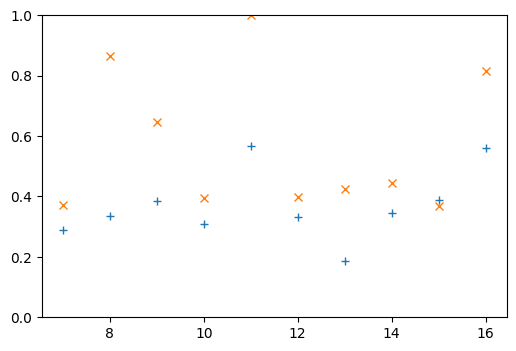

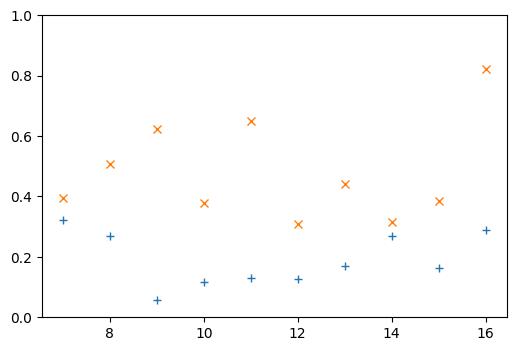

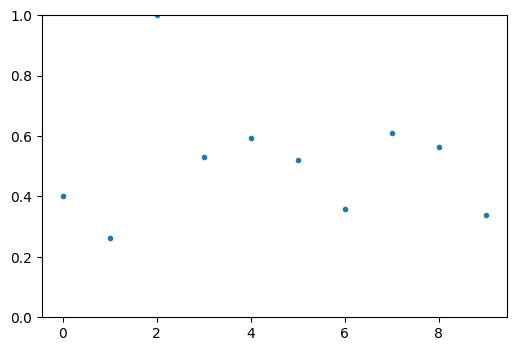

In [43]:
iR = m2.inference_net.get_layer(m2.name+'_iRlv')
gR = m2.generative_net.get_layer(m2.name+'_gRlv')
f = plt.figure()
plt.ylim(0.,1.)
f.set_dpi(100)
plt.plot(range(7,17),iR.weights[0].numpy()[4:14],'+')
plt.plot(range(7,17),iR.weights[0].numpy()[14:24],'x')

f = plt.figure()
plt.ylim(0.,1.)
f.set_dpi(100)
plt.plot(range(7,17),iR.weights[0].numpy()[24:34],'+')
plt.plot(range(7,17),iR.weights[0].numpy()[34:44],'x')


f = plt.figure()
plt.ylim(0.,1.)
f.set_dpi(100)
plt.plot(range(10),gR.weights[0].numpy(),'.')


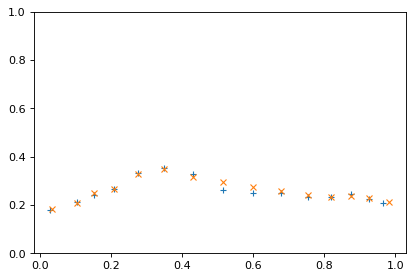

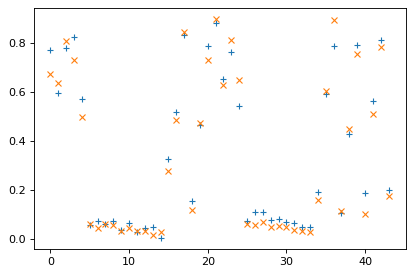

In [381]:
pos +=1
fig = plt.figure('m1m2 test')
fig.set_dpi(80)
#ax1, ax2 = plt.subplots(1,2)

plt.ylim(0.,1.)

d1 = [x for x in ds_m1.skip(pos).batch(1).take(1)][0][0]
d2 = [x for x in ds_m2.skip(pos).batch(1).take(1)][0][0]
D1 = m1.call(d1, training=False)

d1 = tf.reshape(d1,[-1])
x,y = tf.split(d1, num_or_size_splits=2)
plt.plot(x,y,'+')

D1 = tf.reshape(D1,[-1])
X,Y = tf.split(D1, num_or_size_splits=2)
plt.plot(X,Y,'x')

fig = plt.figure('m2 test')
fig.set_dpi(80)
plt.plot(range(44), d2[0], '+')
D2 = m2.call(d2, training=False)
plt.plot(range(44), D2[0], 'x')


In [82]:
def   batch(x): return tf.reshape(x, [1,-1])
def unbatch(x): return tf.reshape(x, [-1])
def xym2_map(xy,pBr):
    pBr = batch(pBr)
    pBr,_ = m2.encode(pBr, training=False)
    pBr = unbatch(pBr)
    xypBr = tf.concat([xy,pBr], axis=0)
    return xypBr,xypBr
ds_xym2 = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F~absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,pbr: xym2_map(x,pbr) )
# [x for x in ds_xym2.take(1)][0]

In [83]:
m_xym2 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=30+m2.latent_dim, beta=1e-5, scale=1, name='m_xym2', geometry=[20,20,10,10])

AEFIT5 ready m:


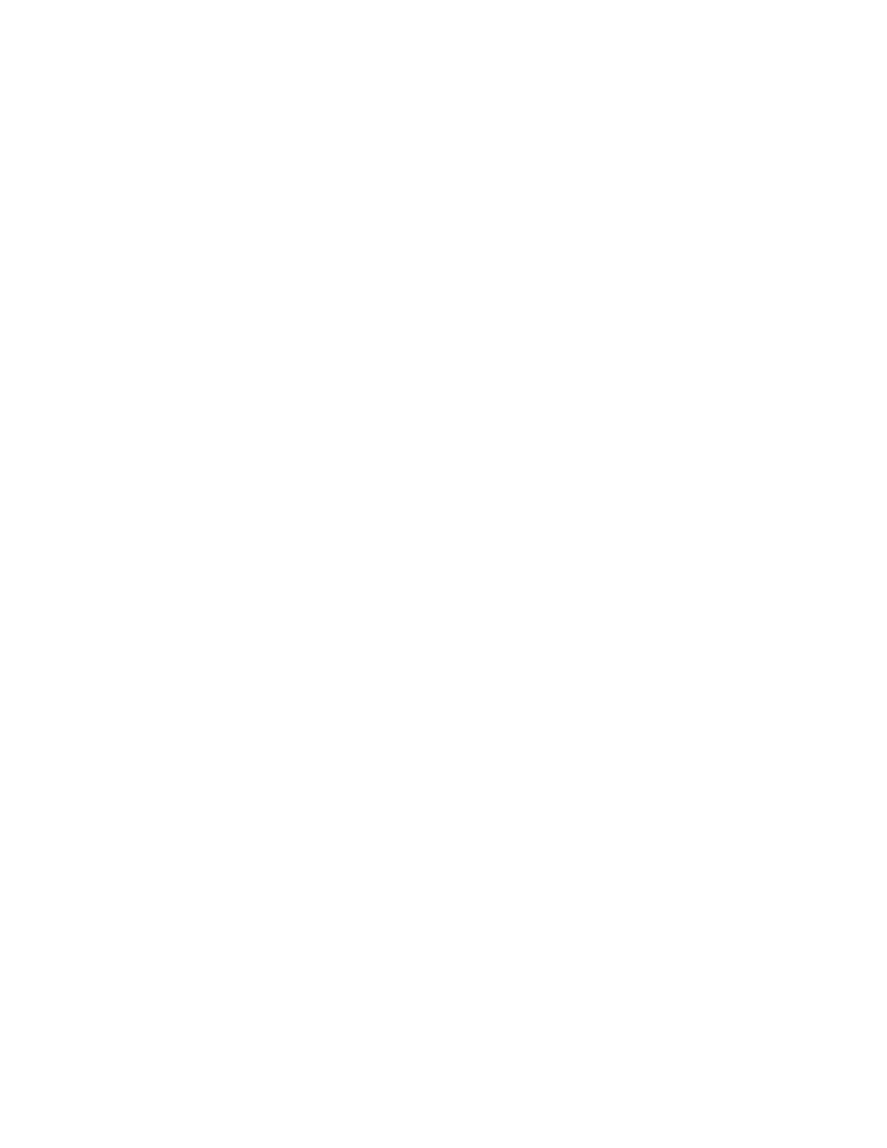

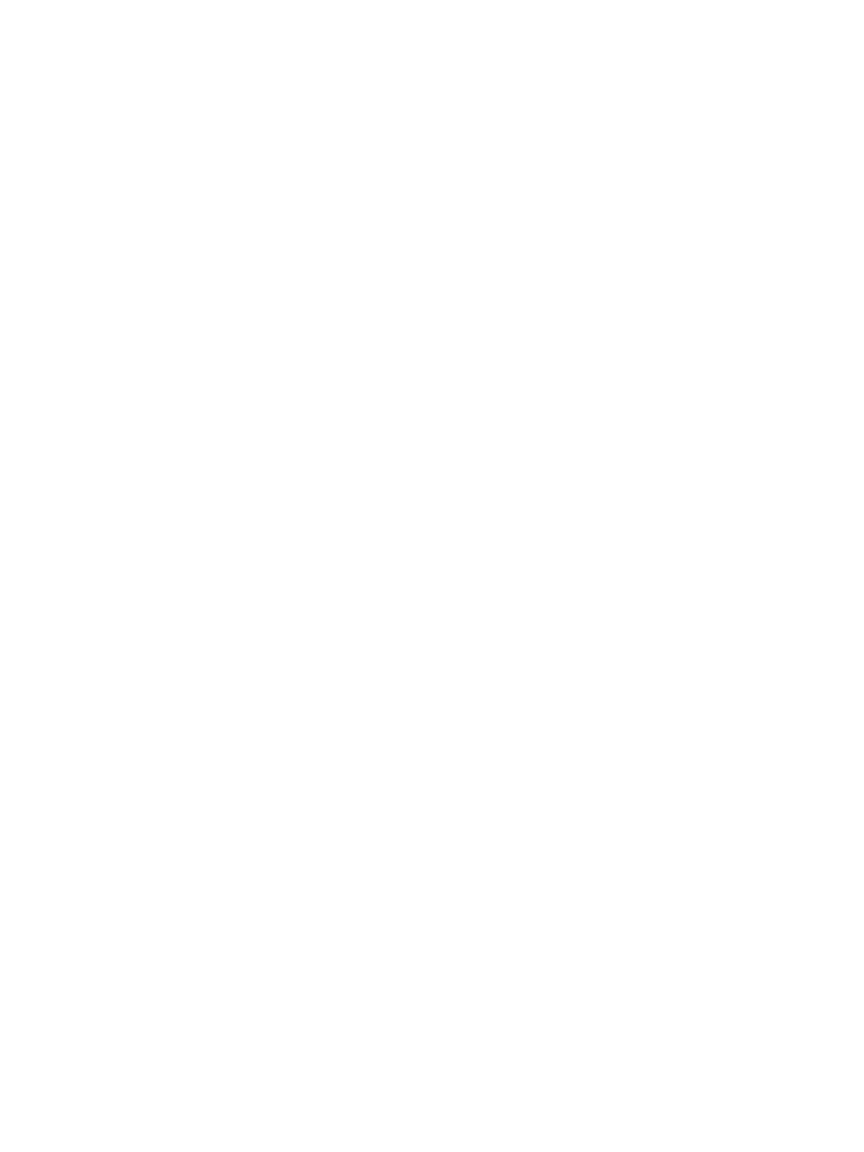

<lambda> (cost function):
training   (min:    0.001, max:    0.024, cur:    0.001)
validation (min:    0.001, max:    0.003, cur:    0.001)

mse:
training   (min:    0.001, max:    0.023, cur:    0.001)
validation (min:    0.001, max:    0.003, cur:    0.001)

akl:
training   (min:   40.285, max:   45.327, cur:   40.348)
validation (min:   39.161, max:   45.931, cur:   40.653)

mkl:
training   (min:   39.596, max:   46.150, cur:   42.829)
validation (min:   41.669, max:   46.237, cur:   43.164)

b:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)
406/50 [===================================================================================================================================================================================================================================================] - 46s 114ms/step - loss: 0.0012 - mse: 6.5764e-04 - akl: 40.3479 - mkl: 42.8290 - b: 1.0000e-05


Exception in thread async train:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/nbmultitask.py", line 148, in run
    fn(*self._args,**self._kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 351, in <lambda>
    super(AsyncTrain, self).__init__(target=lambda thread_print: fn(), name='async train')
  File "<ipython-input-85-5f5b0c98abce>", line 5, in fit_xym2
    callbacks=[PlotLossesCallback()], shuffle=False, epochs=200)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ker

In [85]:
def fit_xym2():
    global h_xym2
    ds = ds_xym2
    h_xym2 = m_xym2.fit( ds.skip(5000).batch(100), validation_data=ds.take(5000).batch(100), 
             callbacks=[PlotLossesCallback()], shuffle=False, epochs=200)
models.base.fn_thread(m_xym2,fit_xym2).control_panel()

In [353]:
# m_xym2.save('STEP12_xym2')
m_xym2.load('STEP12_xym2')

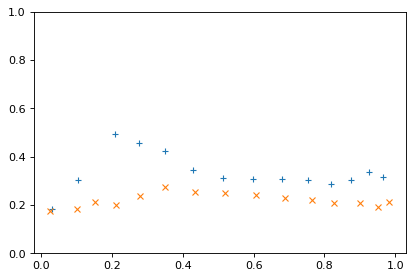

In [358]:
pos += 1
fig = plt.figure('xym2')
fig.set_dpi(80)
d = [q for q in ds_xym2.skip(pos).batch(1).take(1)][0][0]
x,y = tf.split(tf.reshape(d,[-1])[0:30],2)
plt.ylim(0.,1.)
plt.plot(x,y,'+', label='DSX3')
D = m_xym2.call(d, training=False)
X,Y = tf.split(tf.reshape(D,[-1])[0:30],2)
plt.plot(X,Y,'x', label='m_xym2')

# Direct train a VAE withing latent space by dataset mapping
This uses a map function to compose the latent space of both m1 and m2 into a new dataset suitable to be fed in a further VAE model
in this way there is not the inputs separation, i.e. the dataset output is the direct concatenation of the two latent values.

The loss function is one for both and no weighting is possible but the loss should be distributed accordingly to the error on measure.

In [7]:
def   batch(x): return tf.reshape(x, [1,-1])
def unbatch(x): return tf.reshape(x, [-1])
def m1m2_map(xy,Br):
    xy = batch(xy)
    Br = batch(Br)
    xy,_ = m1.encode(xy, training=False)
    Br,_ = m2.encode(Br, training=False)
    xy = unbatch(xy)
    Br = unbatch(Br)
    xyBr = tf.concat([xy,Br], axis=0)
    return xyBr,xyBr
DS = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F~absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,br: m1m2_map(x,br) )
[x for x in DS.take(1)][0]

(<tf.Tensor: id=1107, shape=(16,), dtype=float32, numpy=
 array([-1.5540247 ,  0.00213373,  1.2013704 ,  0.00475165,  0.96793544,
        -0.00752708, -0.13408281, -1.8331757 , -1.0122573 ,  1.1023388 ,
         0.41006067,  0.17837657,  0.1385765 , -0.26530972, -0.37714368,
        -0.132154  ], dtype=float32)>,
 <tf.Tensor: id=1108, shape=(16,), dtype=float32, numpy=
 array([-1.5540247 ,  0.00213373,  1.2013704 ,  0.00475165,  0.96793544,
        -0.00752708, -0.13408281, -1.8331757 , -1.0122573 ,  1.1023388 ,
         0.41006067,  0.17837657,  0.1385765 , -0.26530972, -0.37714368,
        -0.132154  ], dtype=float32)>)

In [64]:
m1.trainable = False
m2.trainable = False
hm_feature_dim = m1.latent_dim + m2.latent_dim
m3 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=hm_feature_dim, beta=1e-5, scale=1, name='m3_hidden', geometry=[20,20,20,10,10])

AEFIT5 ready m:


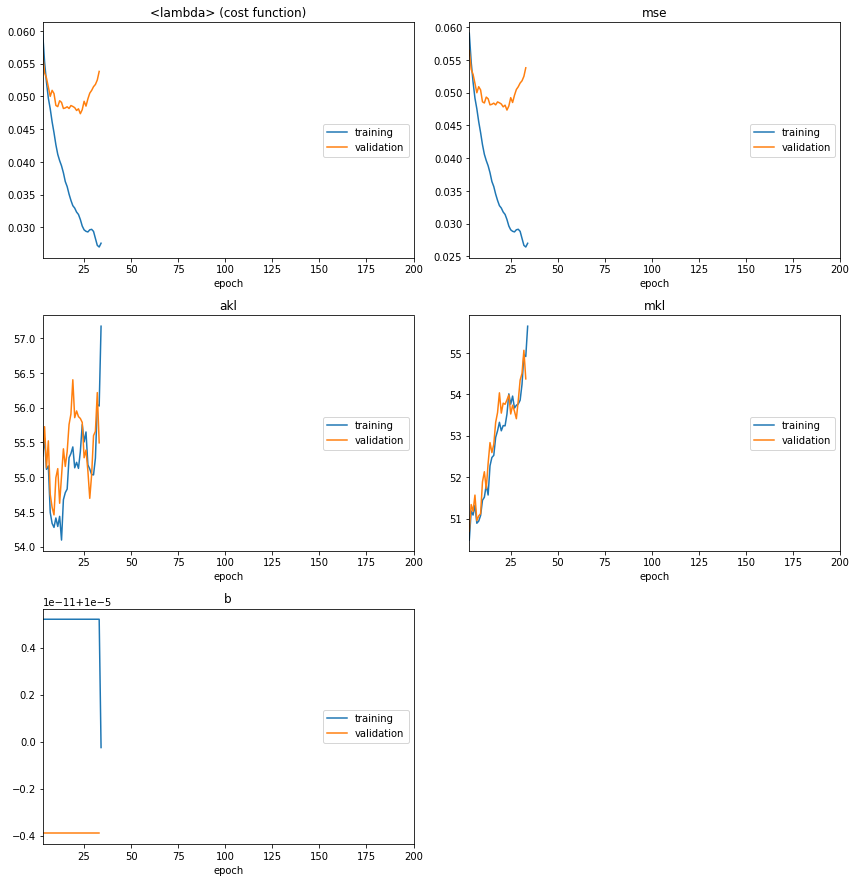

<lambda> (cost function):
training   (min:    0.027, max:    0.233, cur:    0.028)
validation (min:    0.047, max:    0.074, cur:    0.054)

mse:
training   (min:    0.026, max:    0.232, cur:    0.027)
validation (min:    0.047, max:    0.074, cur:    0.054)

akl:
training   (min:   37.843, max:   57.174, cur:   57.174)
validation (min:   53.847, max:   56.402, cur:   55.495)

mkl:
training   (min:   32.996, max:   55.646, cur:   55.646)
validation (min:   47.253, max:   55.064, cur:   54.373)

b:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)
 1/50 [..............................] - ETA: 4:27 - loss: 0.0276 - mse: 0.0270 - akl: 57.1737 - mkl: 55.6457 - b: 1.0000e-05

Exception in thread async train:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/nbmultitask.py", line 148, in run
    fn(*self._args,**self._kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 351, in <lambda>
    super(AsyncTrain, self).__init__(target=lambda thread_print: fn(), name='async train')
  File "<ipython-input-65-cc3bcfa31fd9>", line 4, in fit3
    callbacks=[PlotLossesCallback()], shuffle=False, epochs=200)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/e

In [65]:
def fit3():
    global h3
    h3 = m3.fit( DS.skip(5000).batch(100).take(100), validation_data=DS.take(5000).batch(100), 
             callbacks=[PlotLossesCallback()], shuffle=False, epochs=200)
models.base.fn_thread(m3,fit3).control_panel()

In [ ]:
# ## TEST on direct conversion
# pos = 0
# # [ v.name for v in h2.trainable_variables ]
# fig = plt.figure('m3 test')
# fig.set_dpi(150)

# def plot(xy, tag='.', label=None):
#     ax = plt.gca()
#     ax.set_ylim(0.,.8)
#     x,y = tf.split(xy[0], num_or_size_splits=2)
#     plt.plot(x,y,tag, label=label)
#     plt.legend()

# d = [x for x in ds.shuffle(100).batch(1).take(100)][0]
# xy = d[0][0]
# XY = m1(xy, training=False)
# plot(xy,'+','original')
# plot(XY,'x','m1')

# d_param = d[0]
# d_param = ( tf.zeros_like(d[0][0]), d[0][1] ) # spengo SXR e tengo i parametri
# # y0 = h(d[0], training=False)
# y0 = h(d_param, training=False)[0]
# # y0 = tf.sigmoid(y0)
# # plot(d0)
# plot(y0,'.','h')

# COMPOSE MODEL
This uses the models.Compose class that build a model for the separated inputs.

The problem seems to be the difference on the two loss values that are several orders of magniture higher for parameters so the network does not train on the DSX3.

In [ ]:
hm_feature_dim = m1.latent_dim + m2.latent_dim
hm = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=hm_feature_dim, beta=0., scale=1, name='hidden', geometry=[10,20,20,10])
h = models.Compose.Compose().set_model(hm).compose([m1,m2])

In [8]:
m1.trainable = False
m2.trainable = False
hm.trainable = True

h.loss_scale = [0.,1.]
h.compile( loss = tf.keras.losses.mse )

NameError: name 'hm' is not defined

In [ ]:
# callbacks=[PlotLossesCallback()]
def fit():
    global history
    history = h.fit( ds.skip(5000).batch(100).take(100), validation_data=ds.take(5000).batch(100), shuffle=False, epochs=200)
# models.base.fn_thread(h, fit).control_panel()
fit()

In [ ]:
# [ v.name for v in h2.trainable_variables ]
fig = plt.figure('data')
fig.set_dpi(150)

def plot(xy, tag='.', label=None):
    ax = plt.gca()
    ax.set_ylim(0.,.8)
    x,y = tf.split(xy[0], num_or_size_splits=2)
    plt.plot(x,y,tag, label=label)
    plt.legend()
d = [x for x in ds.shuffle(100).batch(1).take(100)][0]
xy = d[0][0]
XY = m1(xy, training=False)
plot(xy,'+','original')
plot(XY,'x','m1')

d_param = d[0]
d_param = ( tf.zeros_like(d[0][0]), d[0][1] ) # spengo SXR e tengo i parametri
# y0 = h(d[0], training=False)
y0 = h(d_param, training=False)[0]
# y0 = tf.sigmoid(y0)
# plot(d0)
plot(y0,'.','h')



In [ ]:
# tbordo tcentro Ip NS VT F
xy,_ =  [x for x in ds.batch(1).take(1)][0]
par = xy[2]

l,_ = h.encode(xy, training=False)
XY  = h.decode(l, training=False, apply_sigmoid=True) 
PAR = XY[2]

print( list(zip(par, PAR)) )


In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)

# sx = []
# sy = []
# for xy in ds.batch(1).take(1000):
#     xy,_ = xy
#     x,y = tf.split(xy[0],2, axis=1)
#     me,_  = h.encode(xy, training=False)
#     gpt = me[0].numpy()
#     #ax1.scatter(gpt[0],gpt[1])
#     sx.append(gpt[0])
#     sy.append(gpt[1])

# ax1.scatter(sx,sy)
    
for xy in ds.shuffle(100).batch(1).take(1):    
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    ax2.scatter(x,y,s=80)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = h.decode(me, training=False)[0]
    XY = tf.sigmoid(XY)
    X,Y = tf.split(XY[0], num_or_size_splits=2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1

In [ ]:
xy,_ = [x for x in ds.batch(2).take(1)][0]
me,va = h.encode(xy)
XY = h.decode(me, apply_sigmoid=True)
XY[0][0]